In [1]:
%matplotlib inline
import json 
import matplotlib.pyplot as plt
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import keras 

# import numpy
# import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
import tensorflow as tf


from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix


from keras import backend as K

Using TensorFlow backend.
/home/omid/.conda/envs/iot_new/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


# Main configs

In [2]:
loadFromMerged=True
loadFromIndexes= True
Mapper='SE'
IgnoreEmpty= False
FoldID ="1"
Epoch_count=100
Batch_size=5000

# Load the data the old way


In [3]:
# x_data= [] 
# y_data= [] 


# with open( '../files/txt/seq_mapping_large.txt' ) as f:
#     x_data =   f.readlines()

# with open( '../files/txt/command_mapping_large.txt' ) as f:
#     y_data = f.readlines()
    
    
# x_data =[ np.array([ int(y) for y in x.strip().split( ' ') ])   for x in  x_data ] 
# y_data =[ x.strip().split(' ') for x in  y_data ] 


#  Load The Data The New Way

In [4]:
#  mapps the input records to a integer array for the input
def mapping_x( inp, includeDirection = False ):
    if includeDirection:
        return np.array([ int(x["packet_length"]) * (1 if x['packet_source']=='hub' else -1) for x in inp ])
    else:
        return np.array([ int(x["packet_length"])  for x in inp ])

In [5]:
def mapping_y_service(inp):
    return np.array(  list(set([x["event"] for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_service_event(inp):
    return np.array(  list(set([ "%s-%s"%( x["event"] ,x["val"] ) for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_device_service(inp):
    return np.array(  list(set([ "%s & %s"%( x["device"] ,x["event"] ) for x in inp])) if (len(inp )>0) else ["none"] )

def mapping_y_full(inp):
    return np.array(  list(set([ "%s & %s & %s"%( x["device"] ,x["event"], x['val'] ) for x in inp])) if (len(inp )>0) else ["none"] )


In [6]:
# this cleans the data removing emply nodes and turning the nodes into sarrays by calling the mapping function 
def clean_data( x_data, y_data , removeempty=True, Mapping='S'):
    cleans = [] 
    cleans = sorted([ x for x in y_data if (removeempty and len(y_data[x]) > 0) or not removeempty  ] )
    
    ret_x  = [x_data[x] for x in cleans]
    ret_y  = [y_data[x] for x in cleans] 
    
    ret_x  = [ mapping_x(x) for x in ret_x ] 
    if Mapping=='S':
        ret_y  = [ mapping_y_service(y) for y in ret_y ]
    elif Mapping=='SE':
        ret_y  = [ mapping_y_service_event(y) for y in ret_y ]
    elif Mapping=='DS':
        ret_y  = [ mapping_y_device_service(y) for y in ret_y ]
    elif Mapping=='F':
        ret_y  = [ mapping_y_full(y) for y in ret_y ]
    return ret_x, ret_y

In [7]:
x= []
y= []

x_test = {}
y_test = {}

x_train = {}
y_train = {}



if loadFromMerged:
    with open(  '../files/train/merged/hub_segments_2.json'  ) as f:
        y_data = json.load(f)

    with open(  '../files/train/merged/pcap_segments_2.json'  ) as f:
        x_data = json.load(f)

    if len( y_data ) != len(x_data) :
        print( pick )
    #     continue

    with open("../files/train/merged/items_2_test-train_indexes.json")  as f:
        index_info = json.load(f)
    
    
    for i in index_info[FoldID]["test"]:
        x_test[str(i)]=( x_data[str(i)] )
        y_test[str(i)]=(  y_data[str(i)] )
    
    for i in index_info[FoldID]["train"]:
        x_train[str(i)]=(  x_data[str(i)] )
        y_train[str(i)]=(  y_data[str(i)] )
    
#     x_test = x_data[ index_info["1"]["test"]  ]
#     y_test = y_data[ index_info["1"]["test"]  ]
    
#     x_train = x_data[ index_info["1"]["train"]  ]
#     y_train = y_data[ index_info["1"]["train"]  ]
    
    
    x_test,y_test= clean_data( x_test, y_test, IgnoreEmpty , Mapping=Mapper)
    x_train,y_train= clean_data( x_train, y_train, IgnoreEmpty , Mapping=Mapper )

#     x.extend(t_x)
#     y.extend(t_y)
else:
    for pick in glob.glob( '../files/train/hub_segments/*.json' ):
        fname  = os.path.basename(pick)
        with open( os.path.join( '../files/train/hub_segments/', fname) ) as f:
            y_data = json.load(f)

        with open( os.path.join('../files/train/pcap_segments/', fname) ) as f:
            x_data = json.load(f)

        if len( y_data ) != len(x_data) :
            print( pick )
            continue

        t_x,t_y= clean_data( x_data, y_data, True )

        x.extend( t_x)
        y.extend(t_y)

x= np.array( x )
y= np.array(y)

len(x_train), len(y_test)

(50358, 12590)

In [8]:
classes = sorted(list(np.unique(  np.concatenate( y_train  ))))
[ (i , classes[i]) for i in range( len(classes) ) ]




[(0, 'acceleration-active'),
 (1, 'acceleration-inactive'),
 (2, 'activity-hubDisconnected'),
 (3, 'activity-offline'),
 (4, 'activity-online'),
 (5, 'battery-XXX'),
 (6, 'button-held'),
 (7, 'button-pushed'),
 (8, 'colorTemperature-XXX'),
 (9, 'contact-closed'),
 (10, 'contact-open'),
 (11, 'level-XXX'),
 (12, 'lock-locked'),
 (13, 'lock-unlocked'),
 (14, 'motion-active'),
 (15, 'motion-inactive'),
 (16, 'none'),
 (17, 'ping-ping'),
 (18, 'status-closed'),
 (19, 'status-open'),
 (20, 'switch-off'),
 (21, 'switch-on'),
 (22, 'temperature-XXX'),
 (23, 'threeAxis-XXX'),
 (24, 'water-dry'),
 (25, 'water-wet')]

In [9]:
def is_clean( inp, return_clean= True  ):
    if return_clean:
        return  'switch-off' not in inp and 'switch-on' not in inp
    else:
        return  'switch-off' in inp or 'switch-on'  in inp
#     return  "contact-open" not in inp and 'contact-closed' not in inp

In [10]:
y_train[0]

array(['switch-on', 'level-XXX'], dtype='<U9')

In [11]:
toKeep = [ i for i in range(len(y_train)) if is_clean( y_train[i]) ]
x_train= [ x_train[i] for i in toKeep ]
y_train= [ y_train[i] for i in toKeep ]


In [12]:
toChange= [ i for i in range(len(y_test)) if is_clean( y_test[i], False) ]
y_test_2 = [ (y_test[i] if i not in toChange else np.array( ['none'])) for i in range(len(y_test)) ]

In [13]:
classes.remove('switch-off')
classes.remove('switch-on')

In [14]:
def pre_process_raw( x_data,y_data, dim_size = 128, zero_pad = False, normalize = False ,classes=None ):
#  y data 
    if classes is None:
        classes  = sorted(list(np.unique(  np.concatenate( y_data  ))))
    else :
        classes = sorted(classes)
    y_data_categorical = []  

    for x in y_data:
        temp = np.zeros( len(classes) )
        for y in x : 
            temp[ classes.index( y ) ] = 1
        y_data_categorical.append( temp )
    y_data_categorical = np.vstack(y_data_categorical)

#     x_data = np.array( x_data) / 1500.0
    
    x_data_temp = [] 
    
    if not zero_pad:
        for x in x_data:
            temp = [] #list(x)
            lst = list(x)
            while dim_size**2 - len(temp )   > len(lst):
                temp.extend(lst)

            while len(temp) < dim_size**2:
                temp.append( 0 )

            x_data_temp.append(np.array( temp).reshape(dim_size,dim_size))


        x_data_temp = np.array( x_data_temp )
        x_data_temp=x_data_temp.reshape(x_data_temp.shape+(1,))
    else :
        x_data_temp = sequence.pad_sequences(x_data, maxlen=dim_size)
    
    
    if normalize:
        x_data_temp = np.array( x_data_temp) / 1500.0
    else :
        x_data_temp = np.array(x_data_temp)
    
    
    return x_data_temp ,y_data_categorical , classes

# Model Evaluation Methods

In [15]:
y_lstm_prossed_test[2]

NameError: name 'y_lstm_prossed_test' is not defined

In [16]:
temp = np.sum( y_lstm_prossed_test.astype(int) , axis=0)
temp

NameError: name 'y_lstm_prossed_test' is not defined

In [15]:
def make_recall_shit( inp ):
    tp = inp[1][1]
    tn = inp[0][0]
    fp = inp[0][1] 
    fn = inp[1][0]
    
    acc = (tp+tn)*1.0 / ( tp+tn+fp+fn)*1.0
    recall = tp*1.0/ ( tp+fn ) *1.0
    prec = tp*1.0 / ( tp+fp )*1.0
    
    F= 2.0*( prec* recall )/ (prec+recall)
    
    return acc, recall, prec, F
def print_info(y_test, pred , classes , confidance=0.5 ):
    
    counts = np.sum( y_test.astype(int) , axis=0)
    
    pred[pred>=confidance] = 1
    pred[pred<confidance] = 0
    conf= multilabel_confusion_matrix( y_test , pred.astype(int), labels= range(len(classes)))
    accs = [make_recall_shit(x) for x in conf]
    print( "%30s  %8s   %8s  %8s  %8s %8s"  %( "Class","Accuracy", "Recall","Precision","F Score" , "Count"))
    print( "------------------------------------------------------------------------" )
    for index in range(len(classes)):
        print( "%30s  %8.3f   %8.3f  %8.3f  %8.3f  %8d "  %
             (classes[index],
              accs[index][0],
              accs[index][1],
              accs[index][2],
              accs[index][3],
              counts[index]
             )

             )
    

# Create the Model 

In [274]:
import numpy as np
import os
import tensorflow as tf
from keras.models import Model

from keras.layers import Input, merge, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, Dropout, Conv2DTranspose, UpSampling2D, Lambda
from keras.layers import Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization as bn
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.optimizers import RMSprop
from keras import regularizers
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.layers.merge import add
from keras.models import load_model
import numpy as np
from keras.regularizers import l2

def unet(dim_size , classcount):
    l2_lambda = 0.0002
    DropP = 0.3
    kernel_size=3

    inputs = Input((dim_size,dim_size,1))
    
    
    conv1 = Conv2D( 32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(inputs)
    conv1 = bn()(conv1)
    conv1 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv1)
    conv1 = bn()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(DropP)(pool1)





    conv2 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool1)
    conv2 = bn()(conv2)
    conv2 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv2)
    conv2 = bn()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(DropP)(pool2)



    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool2)
    conv3 = bn()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv3)
    conv3 = bn()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(DropP)(pool3)



    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool3)
    conv4 = bn()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv4)
    conv4 = bn()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    pool4 = Dropout(DropP)(pool4)



    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(pool4)
    conv5 = bn()(conv5)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv5)
    conv5 = bn()(conv5)
    
    up6 = concatenate([Conv2DTranspose(256,(2, 2), strides=(2, 2), padding='same')(conv5), conv4],name='up6', axis=3)
    up6 = Dropout(DropP)(up6)
    conv6 = Conv2D(256,(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up6)
    conv6 = bn()(conv6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv6)

    conv6 = bn()(conv6)
    up7 = concatenate([Conv2DTranspose(128,(2, 2), strides=(2, 2), padding='same')(conv6), conv3],name='up7', axis=3)
    up7 = Dropout(DropP)(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up7)
    conv7 = bn()(conv7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv7)
    conv7 = bn()(conv7)

    up8 = concatenate([Conv2DTranspose(64,(2, 2), strides=(2, 2), padding='same')(conv7), conv2],name='up8', axis=3)
    up8 = Dropout(DropP)(up8)
    conv8 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up8)
    conv8 = bn()(conv8)
    conv8 = Conv2D(64, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv8)
    conv8 = bn()(conv8)

    up9 = concatenate([Conv2DTranspose(32,(2, 2), strides=(2, 2), padding='same')(conv8), conv1],name='up9',axis=3)
    up9 = Dropout(DropP)(up9)
    conv9 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(up9)
    conv9 = bn()(conv9)
    conv9 = Conv2D(32, (kernel_size, kernel_size), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_lambda) )(conv9)
    conv9 = bn()(conv9) 
    
    
    
    flatten1 = Flatten()(conv9)
    conv7 = Dense( 256, activation='relu' )(flatten1)
    conv8 = Dense( 128, activation='relu' )(conv7)
    
    
    output = Dense(classcount,  activation='sigmoid',name='output')(conv8)
    
    model = Model(inputs=[inputs], outputs=[output])
    model.compile(optimizer=Adam(lr=1e-5), loss=weighted_categorical_crossentropy(weights=weights), metrics=['accuracy'])
    return model

In [275]:
dim_size =32
x_train_processed,y_train_processed, _ = pre_process_raw( x_train, y_train , dim_size, classes=classes)
x_test_processed,y_test_processed, _ = pre_process_raw( x_test, y_test_2 , dim_size, classes=classes)


In [276]:
model2 = unet(dim_size,len( y_train_processed[0]))
# model2.summary()


In [59]:
model2.save("UNET_Sigmoid_200Epoch_trainedWithoutSwithces")

 a
 

In [280]:
report2=  model2.fit( x=x_train_processed , y=y_train_processed , batch_size=1800, epochs=100 )

Epoch 1/100
49534/49534 [==============================] - 17s - loss: 32.5335 - acc: 0.7109    
Epoch 2/100
49534/49534 [==============================] - 17s - loss: 32.7872 - acc: 0.7157    
Epoch 3/100
49534/49534 [==============================] - 17s - loss: 32.7717 - acc: 0.7158    
Epoch 4/100
49534/49534 [==============================] - 17s - loss: 32.6108 - acc: 0.7191    
Epoch 5/100
49534/49534 [==============================] - 17s - loss: 32.8331 - acc: 0.7211    
Epoch 6/100
49534/49534 [==============================] - 17s - loss: 32.3746 - acc: 0.7220    
Epoch 7/100
49534/49534 [==============================] - 17s - loss: 32.6235 - acc: 0.7100    
Epoch 8/100
49534/49534 [==============================] - 18s - loss: 32.4221 - acc: 0.7051    
Epoch 9/100
49534/49534 [==============================] - 18s - loss: 32.6083 - acc: 0.7033    
Epoch 10/100
49534/49534 [==============================] - 18s - loss: 32.5061 - acc: 0.7048    
Epoch 11/100
49534/49534 [===

KeyboardInterrupt: 

In [ ]:
model2.save( "UNET_LargeData_F%s_E%d_B%d_M%s_%r" %
            (
            FoldID,
                Epoch_count,
                Batch_size,
                Mapper,
                IgnoreEmpty
            ) 
           )

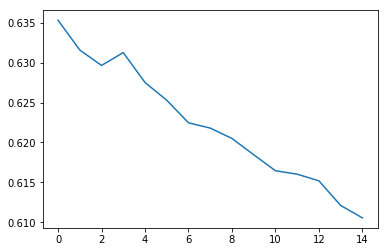

In [28]:
plt.plot(report2.history['loss'])

In [289]:
pred= model2.predict( x_test_processed )


In [292]:
len([x for x in pred if np.sum(x) < 1 ])

2306

In [57]:
len(pred[0]),len( y_test_processed[0]),len(classes)

(24, 24, 24)

In [286]:
print_info(y_test_processed, pred, classes,confidance=0.9)

                         Class  Accuracy     Recall  Precision   F Score    Count
------------------------------------------------------------------------
           acceleration-active     0.993      0.727     0.082     0.147        11 
         acceleration-inactive     0.998      0.000     0.000       nan         9 
      activity-hubDisconnected     0.999        nan     0.000       nan         0 
              activity-offline     0.364      1.000     0.000     0.000         1 
               activity-online     0.993      0.500     0.012     0.024         2 
                   battery-XXX     1.000      0.000       nan       nan         3 
                   button-held     0.999      0.000     0.000       nan         7 
                 button-pushed     0.998      0.771     0.740     0.755        48 
          colorTemperature-XXX     0.999      0.864     0.938     0.899        88 
                contact-closed     0.994      0.590     0.271     0.371        39 
               

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [283]:
pred[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [290]:
print_info(y_test_processed, pred, classes,confidance=0.6)

                         Class  Accuracy     Recall  Precision   F Score    Count
------------------------------------------------------------------------
           acceleration-active     0.993      0.727     0.082     0.147        11 
         acceleration-inactive     0.998      0.000     0.000       nan         9 
      activity-hubDisconnected     0.978        nan     0.000       nan         0 
              activity-offline     0.361      1.000     0.000     0.000         1 
               activity-online     0.993      0.500     0.012     0.024         2 
                   battery-XXX     0.999      0.667     0.133     0.222         3 
                   button-held     0.999      0.000     0.000       nan         7 
                 button-pushed     0.986      0.812     0.195     0.315        48 
          colorTemperature-XXX     0.999      1.000     0.830     0.907        88 
                contact-closed     0.993      0.615     0.264     0.369        39 
               

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [58]:
print_info(y_test_processed, pred, classes,confidance=0.6)

                         Class  Accuracy     Recall  Precision   F Score    Count
------------------------------------------------------------------------
           acceleration-active     0.998      0.273     0.167     0.207        11 
         acceleration-inactive     0.999      0.000     0.000       nan         9 
      activity-hubDisconnected     1.000        nan     0.000       nan         0 
              activity-offline     1.000      0.000       nan       nan         1 
               activity-online     1.000      0.500     1.000     0.667         2 
                   battery-XXX     1.000      0.667     0.400     0.500         3 
                   button-held     0.999      0.143     0.091     0.111         7 
                 button-pushed     0.996      0.042     0.667     0.078        48 
          colorTemperature-XXX     1.000      0.989     0.956     0.972        88 
                contact-closed     0.997      0.051     0.333     0.089        39 
               

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


# Calcualte per class accuracy

In [ ]:
# try:
#     print(X_test is None)
#     np.save( "x_test.npy", X_test )
#     np.save("y_test.npy", y_test)
#     np.save("y_pred.npy", pred )
#     np.save("classes.npy", classes)
# except:
#     X_test = np.load("x_test.npy")
#     y_test = np.load("y_test.npy")
#     pred   = np.load("y_pred.npy")
#     classes = np.load("classes.npy")

# Random Forest baseline calc

In [20]:
dim_size= 75
x_random_forest_train,y_random_forest_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False, classes=classes)
x_random_forest_test,y_random_forest_test, _ = pre_process_raw( x_test, y_test_2 , dim_size, zero_pad=True, normalize=False, classes=classes)
# x,y, classes = pre_process_raw( x_data, y_data , dim_size, zero_pad=True, normalize=True)

In [271]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=960, max_depth=9050,
                             random_state=0 )
t_hist = clf.fit(x_random_forest_train, y_random_forest_train)

rf_pred= clf.predict(x_random_forest_test  )


# print(clf.feature_importances_)

# print(clf.predict([[0, 0, 0, 0]]))
# from sklearn import metrics
# scores = cross_val_score(clf, x_random_forest_train, y_random_forest_train, cv=10, scoring='accuracy')

In [272]:
rf_pred[110]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0.])

In [273]:
print_info(y_random_forest_test, rf_pred, classes)

                         Class  Accuracy     Recall  Precision   F Score    Count
------------------------------------------------------------------------
           acceleration-active     0.999      0.273     0.600     0.375        11 
         acceleration-inactive     0.999      0.000     0.000       nan         9 
      activity-hubDisconnected     1.000        nan       nan       nan         0 
              activity-offline     1.000      0.000       nan       nan         1 
               activity-online     1.000      0.000       nan       nan         2 
                   battery-XXX     1.000      0.333     1.000     0.500         3 
                   button-held     0.999      0.143     0.500     0.222         7 
                 button-pushed     0.999      0.833     0.833     0.833        48 
          colorTemperature-XXX     1.000      1.000     0.946     0.972        88 
                contact-closed     0.997      0.231     0.562     0.327        39 
               

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [261]:
print_info(y_random_forest_test, rf_pred, classes)

                         Class  Accuracy     Recall  Precision   F Score    Count
------------------------------------------------------------------------
           acceleration-active     0.999      0.273     0.429     0.333        11 
         acceleration-inactive     0.999      0.000     0.000       nan         9 
      activity-hubDisconnected     1.000        nan       nan       nan         0 
              activity-offline     1.000      0.000       nan       nan         1 
               activity-online     1.000      0.000       nan       nan         2 
                   battery-XXX     1.000      0.333     1.000     0.500         3 
                   button-held     0.999      0.143     0.500     0.222         7 
                 button-pushed     0.999      0.833     0.833     0.833        48 
          colorTemperature-XXX     1.000      1.000     0.946     0.972        88 
                contact-closed     0.997      0.231     0.562     0.327        39 
               

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [ ]:
# print_info(y_random_forest_test, rf_pred, classes)

In [ ]:
# print ( "mean : %f \nstd: %f\nmax:%f" %( scores.mean(), scores.std(), scores.max()) )

# LSTM 

In [19]:
len(classes)

24

In [24]:
# create the model
dim_size =75
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False,classes=classes)
x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test_2 , dim_size, zero_pad=True, normalize=False,classes=classes)



In [83]:
# x_lstm_prossed_test2 = np.expand_dims(x_lstm_prossed_test,axis=1)
# x_lstm_prossed_train2 =np.expand_dims(x_lstm_prossed_train,axis=1)

x_lstm_prossed_test2 = x_lstm_prossed_test.reshape(len(x_lstm_prossed_test),dim_size,1)
x_lstm_prossed_train2 =x_lstm_prossed_train.reshape(len(x_lstm_prossed_train),dim_size,1)

# y_lstm_prossed_test2 = y_lstm_prossed_test.reshape(len(y_lstm_prossed_test),len(classes),1)
# y_lstm_prossed_train2 =y_lstm_prossed_train.reshape(len(y_lstm_prossed_train),len(classes),1)

In [232]:
weights =np.array([1.0/(50.0/50358.0),
1.0/(52.0/50358.0),
1.0/(3.0/50358.0),
1.0/(5.0/50358.0),
1.0/(4.0/50358.0),
1.0/(11.0/50358.0),
1.0/(58.0/50358.0),
1.0/(210.0/50358.0),
1.0/(376.0/50358.0),
1.0/(118.0/50358.0),
1.0/(121.0/50358.0),
1.0/(694.0/50358.0),
1.0/(230.0/50358.0),
1.0/(221.0/50358.0),
1.0/(105.0/50358.0),
1.0/(98.0/50358.0),
1.0/(16560.0/50358.0),
1.0/(30490.0/50358.0),
1.0/(94.0/50358.0),
1.0/(96.0/50358.0),
1.0/(452.0/50358.0),
1.0/(68.0/50358.0),
1.0/(50.0/50358.0),
1.0/(45.0/50358.0),])
weights

array([1.00716000e+03, 9.68423077e+02, 1.67860000e+04, 1.00716000e+04,
       1.25895000e+04, 4.57800000e+03, 8.68241379e+02, 2.39800000e+02,
       1.33930851e+02, 4.26762712e+02, 4.16181818e+02, 7.25619597e+01,
       2.18947826e+02, 2.27864253e+02, 4.79600000e+02, 5.13857143e+02,
       3.04094203e+00, 1.65162348e+00, 5.35723404e+02, 5.24562500e+02,
       1.11411504e+02, 7.40558824e+02, 1.00716000e+03, 1.11906667e+03])

In [233]:

# weights =np.array([1.0/(50.0/50358.0),
# 1.0/(52.0/50358.0),
# 1.0/(3.0/50358.0),
# 1.0/(5.0/50358.0),
# 1.0/(4.0/50358.0),
# 1.0/(11.0/50358.0),
# 1.0/(58.0/50358.0),
# 1.0/(210.0/50358.0),
# 1.0/(376.0/50358.0),
# 1.0/(118.0/50358.0),
# 1.0/(121.0/50358.0),
# 1.0/(694.0/50358.0),
# 1.0/(230.0/50358.0),
# 1.0/(221.0/50358.0),
# 1.0/(105.0/50358.0),
# 1.0/(98.0/50358.0),
# 1.0/(16560.0/50358.0),
# 1.0/(30490.0/50358.0),
# 1.0/(94.0/50358.0),
# 1.0/(96.0/50358.0),
# 1.0/(452.0/50358.0),
# 1.0/(68.0/50358.0),
# 1.0/(50.0/50358.0),
# 1.0/(45.0/50358.0),])
weights =np.array([
1.0, # 50.0
1.0, # 52.0
1.5, # 3.0
1.5, # 5.0
1.5, # 4.0
1.5, # 11.0
1.0, # 58.0
0.80, # 210.0
0.80, # 376.0
0.80, # 118.0
0.80, # 121.0
0.70, # 694.0
0.80, # 230.0
0.80, # 221.0
0.90, # 105.0
0.90, # 98.0
0.40, # 16562.0
0.40, # 30490.0
0.90, # 94.0
0.90, # 96.0
0.80, # 452.0
0.90, # 68.0
0.90, # 50.0
0.90  # 45.0
])

weights = weights*15

In [247]:
## Bidirectional LSTM :D 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import Bidirectional

model2 = Sequential()


def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

weights =np.array([1.0/(50.0/50358.0),
1.0/(52.0/50358.0),
1.0/(3.0/50358.0),
1.0/(5.0/50358.0),
1.0/(4.0/50358.0),
1.0/(11.0/50358.0),
1.0/(58.0/50358.0),
1.0/(210.0/50358.0),
1.0/(376.0/50358.0),
1.0/(118.0/50358.0),
1.0/(121.0/50358.0),
1.0/(694.0/50358.0),
1.0/(230.0/50358.0),
1.0/(221.0/50358.0),
1.0/(105.0/50358.0),
1.0/(98.0/50358.0),
1.0/(16560.0/50358.0),
1.0/(30490.0/50358.0),
1.0/(94.0/50358.0),
1.0/(96.0/50358.0),
1.0/(452.0/50358.0),
1.0/(68.0/50358.0),
1.0/(50.0/50358.0),
1.0/(45.0/50358.0),])
# weights = weights/ np.max(weights)

# model2.add(LSTM(50, input_shape=(dim_size, 1), return_sequences=True))
# model2.add(TimeDistributed(Dense(1, activation='relu')))
# model2.add(Dropout(0.2))
# model2.add(Flatten())
# model2.add(Dense(127, activation='relu'))
# model2.add(Dense(len(classes), activation='sigmoid'))
# # model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])


# # model2.add(Embedding(word_count, dim_size, input_length=dim_size))
# # model2.add(Dropout(0.1))
model2.add(Bidirectional( LSTM(200 ,  recurrent_dropout=0.12, return_sequences=True),input_shape=[dim_size,1],merge_mode='concat'))
model2.add( LSTM(30 ,  recurrent_dropout=0.14, return_sequences=True))
# model2.add(Bidirectional( LSTM(100 ,  recurrent_dropout=0.04, return_sequences=True),merge_mode='concat'))
model2.add(TimeDistributed(Dense(120, activation='relu')))
model2.add(Dropout(0.1))
model2.add(Flatten())
model2.add(Dense(126, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(len(classes), activation='sigmoid'))

model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])

# model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=3500, shuffle=True)





_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_56 (Bidirectio (None, 75, 400)           323200    
_________________________________________________________________
lstm_73 (LSTM)               (None, 75, 30)            51720     
_________________________________________________________________
time_distributed_44 (TimeDis (None, 75, 120)           3720      
_________________________________________________________________
dropout_48 (Dropout)         (None, 75, 120)           0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 9000)              0         
_________________________________________________________________
dense_115 (Dense)            (None, 126)               1134126   
_________________________________________________________________
dropout_49 (Dropout)         (None, 126)               0         
__________

49534/49534 [==============================] - 13s - loss: 43.1932 - acc: 0.6539    
Epoch 71/100
49534/49534 [==============================] - 14s - loss: 42.7396 - acc: 0.6475    
Epoch 72/100
49534/49534 [==============================] - 13s - loss: 42.3183 - acc: 0.6497    
Epoch 73/100
49534/49534 [==============================] - 14s - loss: 42.1984 - acc: 0.6598    
Epoch 74/100
49534/49534 [==============================] - 13s - loss: 41.7654 - acc: 0.6319    
Epoch 75/100
49534/49534 [==============================] - 14s - loss: 41.8120 - acc: 0.6256    
Epoch 76/100
49534/49534 [==============================] - 14s - loss: 42.2527 - acc: 0.6562    
Epoch 77/100
49534/49534 [==============================] - 14s - loss: 42.0331 - acc: 0.6459    
Epoch 78/100
49534/49534 [==============================] - 14s - loss: 42.0084 - acc: 0.6192    
Epoch 79/100
49534/49534 [==============================] - 14s - loss: 42.4438 - acc: 0.6052    
Epoch 80/100
49534/49534 [=======

In [167]:
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=7500, shuffle=True)

Epoch 1/100
49534/49534 [==============================] - 4s - loss: 45.3920 - acc: 0.7092     
Epoch 2/100
49534/49534 [==============================] - 4s - loss: 45.2922 - acc: 0.7111     
Epoch 3/100
49534/49534 [==============================] - 4s - loss: 44.9958 - acc: 0.7102     
Epoch 4/100
49534/49534 [==============================] - 4s - loss: 44.5277 - acc: 0.7093     
Epoch 5/100
49534/49534 [==============================] - 4s - loss: 44.8207 - acc: 0.7078     
Epoch 6/100
49534/49534 [==============================] - 4s - loss: 45.3309 - acc: 0.7112     
Epoch 7/100
49534/49534 [==============================] - 4s - loss: 45.8106 - acc: 0.7109     
Epoch 8/100
49534/49534 [==============================] - 4s - loss: 45.8407 - acc: 0.7126     
Epoch 9/100
49534/49534 [==============================] - 4s - loss: 46.1059 - acc: 0.7110     
Epoch 10/100
49534/49534 [==============================] - 4s - loss: 44.9274 - acc: 0.7102     
Epoch 11/100
49534/49534 [===

49534/49534 [==============================] - 4s - loss: 44.6293 - acc: 0.7083     
Epoch 85/100
49534/49534 [==============================] - 4s - loss: 44.6648 - acc: 0.7080     
Epoch 86/100
49534/49534 [==============================] - 4s - loss: 46.2901 - acc: 0.7080     
Epoch 87/100
49534/49534 [==============================] - 4s - loss: 44.5677 - acc: 0.7076     
Epoch 88/100
49534/49534 [==============================] - 4s - loss: 45.7133 - acc: 0.7076     
Epoch 89/100
49534/49534 [==============================] - 4s - loss: 45.5719 - acc: 0.7076     
Epoch 90/100
49534/49534 [==============================] - 4s - loss: 45.8939 - acc: 0.7091     
Epoch 91/100
49534/49534 [==============================] - 4s - loss: 44.3139 - acc: 0.7084     
Epoch 92/100
49534/49534 [==============================] - 4s - loss: 45.6059 - acc: 0.7079     
Epoch 93/100
49534/49534 [==============================] - 4s - loss: 45.5793 - acc: 0.7100     
Epoch 94/100
49534/49534 [=======

In [ ]:

# word_count = len(np.max( x_lstm_prossed_train))+1 # len(np.unique( x ))

# create the model
embedding_vecor_length = 102
model2 = Sequential()
# model2.add(Embedding(word_count, dim_size, input_length=dim_size))
# model2.add(Dropout(0.1))
model2.add(LSTM(100 , dropout=0.2, recurrent_dropout=0.2, input_shape=[1,dim_size]))
model2.add(Dropout(0.1))
model2.add(Dense(127, activation='relu'))
model2.add(Dense(len(classes), activation='sigmoid'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=300, batch_size=1500)




# word_count = len(np.unique( x_lstm_prossed_train))+1 # len(np.unique( x ))

# # create the model
# embedding_vecor_length = 102
# model2 = Sequential()
# model2.add(Embedding(word_count, dim_size, input_length=dim_size))
# model2.add(Dropout(0.1))
# model2.add(LSTM(100 , dropout=0.2, recurrent_dropout=0.2))

# model2.add(Dense(127, activation='relu'))
# model2.add(Dense(len(classes), activation='sigmoid'))
# model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model2.summary())
# hist2 = model2.fit(x_lstm_prossed_train, y_lstm_prossed_train, epochs=300, batch_size=1500)


# word_count = np.max( x_lstm_prossed_train)+1 # len(np.unique( x ))

# # create the model
# embedding_vecor_length = 102
# model2 = Sequential()
# model2.add(Embedding(word_count, embedding_vecor_length, input_length=dim_size))
# model2.add(Dropout(0.1))
# model2.add(LSTM(100))

# model2.add(Dense(127, activation='relu'))
# model2.add(Dense(len(classes), activation='sigmoid'))
# model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# print(model2.summary())
# hist2 = model2.fit(x_lstm_prossed_train, y_lstm_prossed_train, epochs=Epoch_count, batch_size=Batch_size)

In [255]:
model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer=keras.optimizers.Adam(lr=8e-5  ), metrics=['accuracy'])

In [234]:
model2.compile(loss=weighted_categorical_crossentropy(weights=weights), optimizer='adam', metrics=['accuracy'])

In [256]:
hist2 = model2.fit(x_lstm_prossed_train2, y_lstm_prossed_train, epochs=100, batch_size=3500, shuffle=True)

Epoch 1/100
49534/49534 [==============================] - 20s - loss: 38.3745 - acc: 0.6707    
Epoch 2/100
49534/49534 [==============================] - 14s - loss: 37.4301 - acc: 0.6762    
Epoch 3/100
49534/49534 [==============================] - 14s - loss: 37.9734 - acc: 0.6782    
Epoch 4/100
49534/49534 [==============================] - 14s - loss: 38.2002 - acc: 0.6789    
Epoch 5/100
49534/49534 [==============================] - 14s - loss: 37.9819 - acc: 0.6785    
Epoch 6/100
49534/49534 [==============================] - 14s - loss: 37.8650 - acc: 0.6785    
Epoch 7/100
49534/49534 [==============================] - 14s - loss: 37.6077 - acc: 0.6798    
Epoch 8/100
49534/49534 [==============================] - 14s - loss: 37.7465 - acc: 0.6782    
Epoch 9/100
49534/49534 [==============================] - 14s - loss: 38.0739 - acc: 0.6772    
Epoch 10/100
49534/49534 [==============================] - 14s - loss: 37.9939 - acc: 0.6771    
Epoch 11/100
49534/49534 [===

KeyboardInterrupt: 

In [42]:
model2.save( "LSTM-sigmoid-withRemovedClasses" )

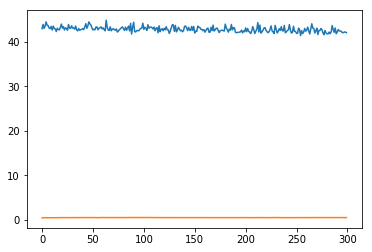

In [156]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['acc'])

In [35]:
# from keras.models import load_model
# model2=load_model( "LSTM_withSigmoid_LargeData_F1_E100_B500_MSE_False"  
#            )

In [257]:
lstm_pred =model2.predict( x_lstm_prossed_test2)


In [258]:
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.60)

                         Class  Accuracy     Recall  Precision   F Score    Count
------------------------------------------------------------------------
           acceleration-active     0.998      0.364     0.143     0.205        11 
         acceleration-inactive     0.999      0.000     0.000       nan         9 
      activity-hubDisconnected     0.989        nan     0.000       nan         0 
              activity-offline     0.349      1.000     0.000     0.000         1 
               activity-online     1.000      0.500     0.333     0.400         2 
                   battery-XXX     0.995      0.667     0.034     0.065         3 
                   button-held     0.988      0.286     0.013     0.025         7 
                 button-pushed     0.998      0.729     0.814     0.769        48 
          colorTemperature-XXX     0.989      1.000     0.393     0.564        88 
                contact-closed     0.996      0.538     0.356     0.429        39 
               

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [41]:
lstm_pred =model2.predict( x_lstm_prossed_test)
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.6)

                         Class  Accuracy     Recall  Precision   F Score    Count
------------------------------------------------------------------------
           acceleration-active     0.999      0.182     0.400     0.250        11 
         acceleration-inactive     0.999      0.000     0.000       nan         9 
      activity-hubDisconnected     1.000        nan       nan       nan         0 
              activity-offline     1.000      0.000       nan       nan         1 
               activity-online     1.000      0.000     0.000       nan         2 
                   battery-XXX     1.000      0.333     1.000     0.500         3 
                   button-held     0.999      0.143     0.500     0.222         7 
                 button-pushed     0.999      0.812     0.830     0.821        48 
          colorTemperature-XXX     1.000      1.000     0.967     0.983        88 
                contact-closed     0.997      0.026     0.500     0.049        39 
               

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [26]:
lstm_pred = model2.predict( x_lstm_prossed_test)
print_info(y_lstm_prossed_test, lstm_pred, classes, confidance=0.6)

                         Class  Accuracy     Recall  Precision   F Score    Count
------------------------------------------------------------------------
                  acceleration     0.998      0.100     0.400     0.160        20 
                      activity     1.000      0.000     0.000       nan         3 
                       battery     1.000      0.333     1.000     0.500         3 
                        button     0.999      0.821     0.852     0.836        56 
              colorTemperature     1.000      1.000     0.967     0.983        88 
                       contact     0.996      0.623     0.535     0.576        61 
                         level     0.997      0.880     0.953     0.915       233 
                          lock     0.998      0.831     0.902     0.865        89 
                        motion     0.997      0.650     0.750     0.696        60 
                          none     0.951      0.935     0.919     0.927      4212 
               

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()


In [116]:
print_info(y_lstm_prossed_train, y_lstm_prossed_train, classes, confidance=0.60)

                         Class  Accuracy     Recall  Precision   F Score    Count
------------------------------------------------------------------------
           acceleration-active     1.000      1.000     1.000     1.000        50 
         acceleration-inactive     1.000      1.000     1.000     1.000        52 
      activity-hubDisconnected     1.000      1.000     1.000     1.000         3 
              activity-offline     1.000      1.000     1.000     1.000         5 
               activity-online     1.000      1.000     1.000     1.000         4 
                   battery-XXX     1.000      1.000     1.000     1.000        11 
                   button-held     1.000      1.000     1.000     1.000        58 
                 button-pushed     1.000      1.000     1.000     1.000       210 
          colorTemperature-XXX     1.000      1.000     1.000     1.000       376 
                contact-closed     1.000      1.000     1.000     1.000       118 
               

In [22]:
[x for x  in lstm_pred  if  np.sum(x) > 0 ]

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 

In [45]:
model2.save( "LSTM_withSigmoid_LargeData_F%s_E%d_B%d_M%s_%r" %
            (
            FoldID,
                Epoch_count,
                Batch_size,
                Mapper,
                IgnoreEmpty
            ) 
           )

In [19]:
lstm_pred = model2.predict( x_lstm_prossed_test )

In [33]:
print_info(y_lstm_prossed_test, lstm_pred, classes)

                         Class  Accuracy     Recall  Precision   F Score    Count
------------------------------------------------------------------------
           acceleration-active     0.999      0.000       nan       nan        11 
         acceleration-inactive     0.999      0.000       nan       nan         9 
      activity-hubDisconnected     1.000        nan       nan       nan         0 
              activity-offline     1.000      0.000       nan       nan         1 
               activity-online     1.000      0.000       nan       nan         2 
                   battery-XXX     1.000      0.000       nan       nan         3 
                   button-held     0.999      0.000       nan       nan         7 
                 button-pushed     0.998      0.633     0.886     0.738        49 
          colorTemperature-XXX     1.000      1.000     0.967     0.983        88 
                contact-closed     0.997      0.000       nan       nan        39 
               

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [ ]:
# x_train_muhammed,y_train_muhammed, classes = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False)
# x_test_muhammed,y_test_muhammed, classes = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False)

In [43]:
lstm_pred = model2.predict( x_lstm_prossed_test )
print_info(y_lstm_prossed_test, lstm_pred, classes)

                         Class  Accuracy     Recall  Precision   F Score    Count
------------------------------------------------------------------------
           acceleration-active     0.998      0.091     0.091     0.091        11 
         acceleration-inactive     0.999      0.000     0.000       nan         9 
      activity-hubDisconnected     1.000        nan       nan       nan         0 
              activity-offline     1.000      0.000       nan       nan         1 
               activity-online     1.000      0.000     0.000       nan         2 
                   battery-XXX     1.000      0.333     1.000     0.500         3 
                   button-held     0.999      0.286     0.154     0.200         7 
                 button-pushed     0.999      0.816     0.833     0.825        49 
          colorTemperature-XXX     1.000      1.000     0.957     0.978        88 
                contact-closed     0.997      0.231     0.500     0.316        39 
               

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [60]:
lstm_pred = model2.predict( x_lstm_prossed_test )
print_info(y_lstm_prossed_test, lstm_pred, classes)

                         Class  Accuracy     Recall  Precision   F Score    Count
------------------------------------------------------------------------
           acceleration-active     0.999      0.273     0.273     0.273        11 
         acceleration-inactive     0.999      0.000     0.000       nan         9 
      activity-hubDisconnected     1.000        nan       nan       nan         0 
              activity-offline     1.000      0.000       nan       nan         1 
               activity-online     1.000      0.000     0.000       nan         2 
                   battery-XXX     1.000      0.333     1.000     0.500         3 
                   button-held     0.999      0.286     0.154     0.200         7 
                 button-pushed     0.998      0.776     0.826     0.800        49 
          colorTemperature-XXX     1.000      1.000     0.957     0.978        88 
                contact-closed     0.997      0.256     0.526     0.345        39 
               

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [52]:
pred[:10]

array([[5.87774157e-05, 4.27929248e-09, 2.76322362e-06, 1.78912509e-04,
        8.38081746e-08, 8.88765207e-05, 1.22838872e-04, 6.57678756e-04,
        9.37186151e-09, 3.10065196e-04, 3.13639088e-04, 1.02921325e-08,
        2.53581442e-04, 3.10868782e-04, 2.79762811e-04, 1.85351542e-04,
        8.80475181e-06, 9.94309187e-01, 3.42802290e-04, 2.33036757e-04,
        3.40680906e-08, 3.47345903e-08, 2.05722102e-03, 5.42194502e-05,
        1.88951235e-04, 4.24953178e-05],
       [7.06665378e-06, 2.65737239e-04, 9.94749838e-10, 2.34846084e-05,
        2.56973820e-09, 7.53053158e-08, 7.20255059e-07, 3.93323171e-05,
        2.08300953e-05, 2.27910841e-05, 1.99705901e-05, 5.09328947e-06,
        4.89148846e-08, 3.06462584e-06, 2.81342946e-05, 2.10101116e-05,
        9.94473636e-01, 5.34877381e-06, 4.69260968e-08, 2.14243755e-05,
        2.22754329e-10, 3.41261158e-10, 5.03325788e-03, 7.00014789e-06,
        2.57263935e-07, 1.68477038e-06],
       [3.40368643e-07, 1.10897736e-05, 3.31280142e-12

In [73]:
print_info(y_lstm_prossed_test, pred, classes)

               Class  Accuracy     Recall  Precision   F Score 
------------------------------------------------------------------------
 acceleration-active     0.999      0.000     0.000       nan 
acceleration-inactive     0.999      0.000       nan       nan 
activity-hubDisconnected     1.000        nan       nan       nan 
    activity-offline     1.000      0.000       nan       nan 
     activity-online     1.000      0.000     0.000       nan 
         battery-XXX     1.000      0.000       nan       nan 
         button-held     0.999      0.143     0.500     0.222 
       button-pushed     0.999      0.816     0.851     0.833 
colorTemperature-XXX     1.000      1.000     0.967     0.983 
      contact-closed     0.997      0.000       nan       nan 
        contact-open     0.998      0.143     1.000     0.250 
           level-XXX     0.995      0.790     0.948     0.862 
         lock-locked     0.999      0.805     0.943     0.868 
       lock-unlocked     0.999      0.8

/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/home/omid/.conda/envs/iot_new/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [44]:
pred[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [42]:
len( y_lstm_prossed_train[0] )

26

In [38]:
dim_size =160
x_lstm_prossed_train,y_lstm_prossed_train, _ = pre_process_raw( x_train, y_train , dim_size, zero_pad=True, normalize=False,classes=classes)
x_lstm_prossed_test,y_lstm_prossed_test, _ = pre_process_raw( x_test, y_test , dim_size, zero_pad=True, normalize=False,classes=classes)

In [71]:
len([x  for x  in y_lstm_prossed_test if x[21]==1 or x[20]==1]), len(y_lstm_prossed_test  ) , len([x  for x  in y_lstm_prossed_test if x[21]==1 or x[20]==1])/len(y_lstm_prossed_test  ) *1.0

(208, 12590, 0.016521048451151706)

In [56]:
[ x for x  in  pred if np.sum(x) > 1]

[array([3.1639295e-06, 1.6172093e-11, 7.4266541e-16, 3.3636210e-13,
        2.0508584e-11, 1.2763182e-10, 3.1314744e-09, 1.4744188e-08,
        1.1362418e-11, 4.1694266e-06, 1.6556285e-05, 1.0592904e-06,
        1.2968698e-10, 7.6627385e-12, 7.4374779e-10, 1.5763238e-12,
        9.9996805e-01, 6.1154463e-12, 9.9790668e-08, 4.2279344e-06,
        1.9755761e-13, 5.1598271e-13, 6.7983856e-12, 2.7392809e-06,
        8.0854532e-09, 4.9655302e-08], dtype=float32),
 array([3.1639295e-06, 1.6172093e-11, 7.4266541e-16, 3.3636210e-13,
        2.0508584e-11, 1.2763182e-10, 3.1314744e-09, 1.4744188e-08,
        1.1362418e-11, 4.1694266e-06, 1.6556285e-05, 1.0592904e-06,
        1.2968698e-10, 7.6627385e-12, 7.4374779e-10, 1.5763238e-12,
        9.9996805e-01, 6.1154463e-12, 9.9790668e-08, 4.2279344e-06,
        1.9755761e-13, 5.1598271e-13, 6.7983856e-12, 2.7392809e-06,
        8.0854532e-09, 4.9655302e-08], dtype=float32),
 array([3.1639295e-06, 1.6172093e-11, 7.4266541e-16, 3.3636210e-13,
      

In [55]:
len(y_lstm_prossed_test)

12590

In [59]:
def do_for_raun( pred   ):
    pp = pred
    pp[pp>=0.5] = 1
    pp[pp<0.5] = 0
    return pp

In [64]:
len([x for x in pred if np.sum( do_for_raun(x) )==0 ])

73

In [66]:
len([x for x in pred if  do_for_raun(x)[20] ==1 or do_for_raun(x)[21] ==1 ])

0

In [ ]:

# np.save("../files/muhammed/x_train.json" , x_train_muhammed)
# np.save("../files/muhammed/y_train.json", )


# np.save( "../files/muhammed/x_train.json", x_train_muhammed )
# np.save("../files/muhammed/y_train.json",  y_train_muhammed )
# np.save( "../files/muhammed/x_test.json",x_test_muhammed )
# np.save( "../files/muhammed/y_test.json",y_test_muhammed )
# np.save( "../files/muhammed/classes.json",  classes )


In [293]:
len(x_lstm_prossed_test) + len(x_lstm_prossed_train)

62124